In [3]:
import cv2
import base64
import matplotlib.pyplot as plt
import time
from matplotlib.gridspec import GridSpec
import os
import numpy as np
import json
from IPython.display import clear_output
from tqdm import tqdm
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from Resnet import ResNet18Embedder
video_path="movie/20241126ikura_full.mp4"

In [4]:

embedder = ResNet18Embedder(device="cpu")

/home/setup/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/setup/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
sim_threshold=0.85
img_list=[]
embed_list=[]

In [38]:
out_jsonl_path="1126out_test.jsonl"

# OpenCVで動画を読み込む
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)  # フレームレートを取得
if fps == 0:  # 万が一fpsが取得できない場合の対処
    fps = 30


# Matplotlibインタラクティブモードを有効にする
plt.ion()

max_frames=3000
cnt=0

# フレームごとにキャプションを生成
while tqdm(cap.isOpened()):
    if cnt>max_frames:
        break
    cnt+=1

    ret, frame = cap.read()
    if not ret:
        break

    img=Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    embed=embedder(img=img)

    sim_list=[]
    for old_embed in embed_list:
        sim=cosine_similarity(embed.reshape(1, -1), old_embed.reshape(1, -1))
        sim_list.append(sim)
    
    if len(sim_list)==0:
        sim_list.append(0)
    min_sim=max(sim_list)
    if min_sim<sim_threshold:
        img_list.append(frame)
        embed_list.append(embed)

    continue
    fig = plt.figure(figsize=(10, 6))  # 全体のサイズを設定
    gs = GridSpec(1, 2, width_ratios=[3, 1])  # 画像:キャプションの幅の比率を3:1に設定

    # 画像を表示（サイズを固定）
    fig.clear()  # 既存の図をクリア

    # 画像部分
    ax_image = fig.add_subplot(gs[0])  # GridSpecの左側に画像
    ax_image.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax_image.axis('off')  # 軸を非表示に


    # 表示をクリアしてから更新
    #print(caption)
    #print(prev_output)
    clear_output(wait=True)
    plt.show()
    #plt.pause(0.1)  # 少し待つことで、リアルタイムに更新

cap.release()
cv2.destroyAllWindows()

In [39]:
len(embed_list)

60

In [41]:
out_dir="out_images"
os.makedirs(out_dir, exist_ok=True)
for i, img in enumerate(img_list):
    cv2.imwrite(f"{out_dir}/{i}.jpg", img)

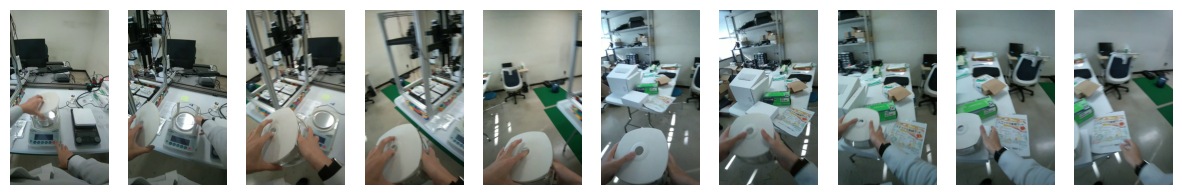

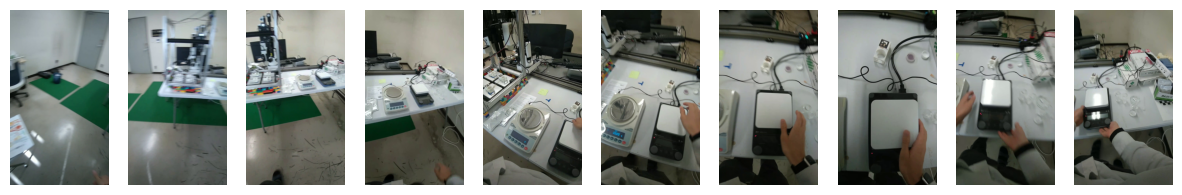

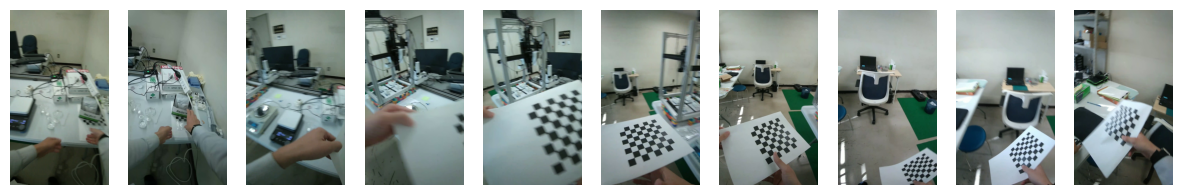

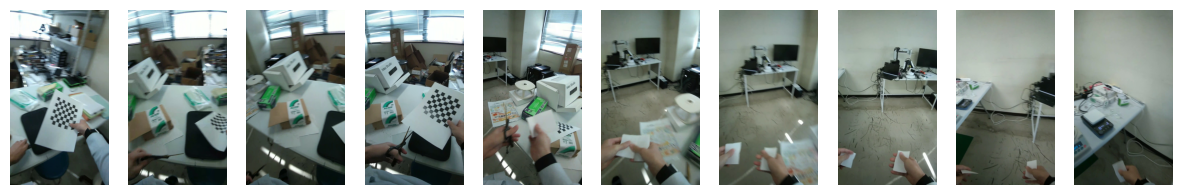

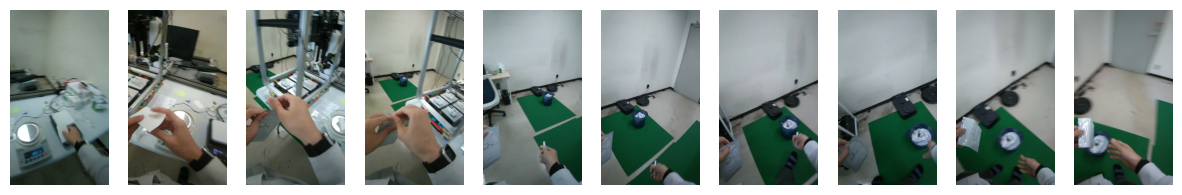

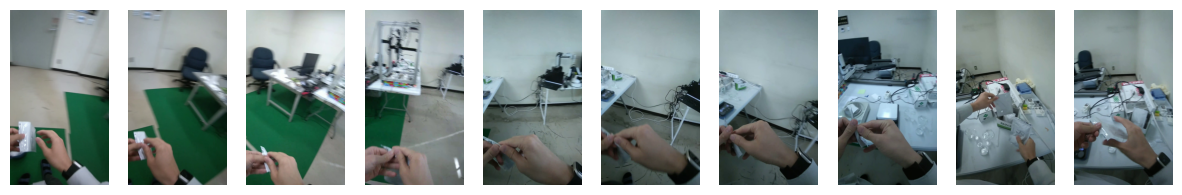

In [40]:
# 画像を表示
#1行あたりの画像数を設定
n_images_per_row = 10

for i in range(0, len(img_list), n_images_per_row):
    fig, axes = plt.subplots(1, n_images_per_row, figsize=(15, 5))
    for ax, img in zip(axes, img_list[i:i+n_images_per_row]):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.show()